In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import print_function
#%matplotlib inline

import numpy as np
import os
from skimage import io 

In [3]:
# Check GPU availability
import torch
print(torch.cuda.is_available())
print(torch.cuda.device_count())

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Use device: {device}')

True
2
Use device: cuda:0


# Dataset

In [5]:
import torchvision.datasets as dset
import torchvision.transforms as transforms

# Root directory for dataset
qr_data = '/home/hideimg/workspace/DeepSteg-master/sample/dataloader'
poster_data = '/home/hideimg/workspace/DeepSteg-master/sample/dataloader2'

# MODELS
MODELS_PATH = '/home/hideimg/workspace/DeepSteg-master/output/models'

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 256

# Batch size during training
batch_size = 8

# Number of workers for dataloader
workers = 2

# We can use an image folder dataset the way we have it setup.
# Create the dataset
qr_dataset = dset.ImageFolder(root=qr_data,
                           transform=transforms.Compose([
                               transforms.Resize((256, 256)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
poster_dataset = dset.ImageFolder(root=poster_data,
                           transform=transforms.Compose([
                               transforms.Resize((256, 256)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
qr_dataloader = torch.utils.data.DataLoader(qr_dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers, drop_last= True)
poster_dataloader = torch.utils.data.DataLoader(poster_dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers, drop_last= True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


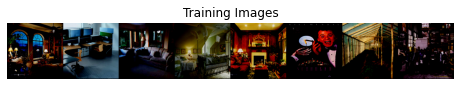

In [9]:
import torchvision.utils as vutils
import matplotlib.pyplot as plt

# Plot some training images
real_batch = next(iter(poster_dataloader))[0].to(device)
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch, padding=2, normalize=False).cpu(),(1,2,0)))

# Model

In [10]:
import torch.nn as nn
import torch.nn.functional as F

In [11]:
# custom weights initialization
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [12]:
def get_same_padding(kernel_size):
    '''
    Calculate padding size for generating the same output dimension as input.
    It only support square kernels and stride=1, dilation=1, groups=1.
    
    Ref: https://github.com/pytorch/pytorch/issues/3867#issuecomment-407663012
    
    Inputs
    -----
        kernel_size
    
    Returns
    ------
        left, right, top, bottom
    '''
    ka = kernel_size // 2
    kb = ka - 1 if kernel_size % 2 == 0 else ka
    return ka, kb, ka, kb

In [13]:
class PreparationNet(nn.Module):
    
    def __init__(self):
        super(PreparationNet, self).__init__()
        self.main = nn.Sequential(
            nn.ZeroPad2d(get_same_padding(kernel_size=4)), 
            nn.Conv2d(3,50,kernel_size=4,stride=1),
#             nn.BatchNorm2d(50),
            nn.ReLU(inplace=True),
            nn.ZeroPad2d(get_same_padding(kernel_size=4)), 
            nn.Conv2d(50,50,kernel_size=4,stride=1),
#             nn.BatchNorm2d(50),
            nn.ReLU(inplace=True),
            nn.ZeroPad2d(get_same_padding(kernel_size=4)), 
            nn.Conv2d(50,50,kernel_size=4,stride=1),
#             nn.BatchNorm2d(50),
            nn.ReLU(inplace=True),
            nn.ZeroPad2d(get_same_padding(kernel_size=2)), 
            nn.Conv2d(50,30,kernel_size=2,stride=1),
#             nn.BatchNorm2d(30),
            nn.ReLU(inplace=True),
            nn.ZeroPad2d(get_same_padding(kernel_size=2)), 
            nn.Conv2d(30,7,kernel_size=2,stride=1),
#             nn.BatchNorm2d(7),
            nn.Tanh(),
        )

    def forward(self, input):
        return self.main(input)
    
# Create the generator
prep_net = PreparationNet().to(device)

# Apply the weights_init function to randomly initialize all weights
prep_net.apply(weights_init)

print(prep_net)

PreparationNet(
  (main): Sequential(
    (0): ZeroPad2d(padding=(2, 1, 2, 1), value=0.0)
    (1): Conv2d(3, 50, kernel_size=(4, 4), stride=(1, 1))
    (2): ReLU(inplace=True)
    (3): ZeroPad2d(padding=(2, 1, 2, 1), value=0.0)
    (4): Conv2d(50, 50, kernel_size=(4, 4), stride=(1, 1))
    (5): ReLU(inplace=True)
    (6): ZeroPad2d(padding=(2, 1, 2, 1), value=0.0)
    (7): Conv2d(50, 50, kernel_size=(4, 4), stride=(1, 1))
    (8): ReLU(inplace=True)
    (9): ZeroPad2d(padding=(1, 0, 1, 0), value=0.0)
    (10): Conv2d(50, 30, kernel_size=(2, 2), stride=(1, 1))
    (11): ReLU(inplace=True)
    (12): ZeroPad2d(padding=(1, 0, 1, 0), value=0.0)
    (13): Conv2d(30, 7, kernel_size=(2, 2), stride=(1, 1))
    (14): Tanh()
  )
)


In [14]:
class HidingNet(nn.Module):
    
    def __init__(self):
        super(HidingNet, self).__init__()
        self.main = nn.Sequential(
            nn.ZeroPad2d(get_same_padding(kernel_size=4)),
            nn.Conv2d(10,50,kernel_size=4,stride=1),
            nn.ReLU(inplace=True),
            nn.ZeroPad2d(get_same_padding(kernel_size=4)),
            nn.Conv2d(50,50,kernel_size=4,stride=1),
            nn.ReLU(inplace=True),
            nn.ZeroPad2d(get_same_padding(kernel_size=4)),
            nn.Conv2d(50,50,kernel_size=4,stride=1),
            nn.ReLU(inplace=True),
            nn.ZeroPad2d(get_same_padding(kernel_size=4)),
            nn.Conv2d(50,50,kernel_size=4,stride=1),
            nn.ReLU(inplace=True),
            nn.ZeroPad2d(get_same_padding(kernel_size=2)),
            nn.Conv2d(50,30,kernel_size=2,stride=1),
            nn.ReLU(inplace=True),
            nn.ZeroPad2d(get_same_padding(kernel_size=2)),
            nn.Conv2d(30,3,kernel_size=2,stride=1),
            nn.Tanh(),
        )

    def forward(self, input):
        return self.main(input)
    
# Create the generator
hide_net = HidingNet().to(device)

# Apply the weights_init function to randomly initialize all weights
hide_net.apply(weights_init)

print(hide_net)

HidingNet(
  (main): Sequential(
    (0): ZeroPad2d(padding=(2, 1, 2, 1), value=0.0)
    (1): Conv2d(10, 50, kernel_size=(4, 4), stride=(1, 1))
    (2): ReLU(inplace=True)
    (3): ZeroPad2d(padding=(2, 1, 2, 1), value=0.0)
    (4): Conv2d(50, 50, kernel_size=(4, 4), stride=(1, 1))
    (5): ReLU(inplace=True)
    (6): ZeroPad2d(padding=(2, 1, 2, 1), value=0.0)
    (7): Conv2d(50, 50, kernel_size=(4, 4), stride=(1, 1))
    (8): ReLU(inplace=True)
    (9): ZeroPad2d(padding=(2, 1, 2, 1), value=0.0)
    (10): Conv2d(50, 50, kernel_size=(4, 4), stride=(1, 1))
    (11): ReLU(inplace=True)
    (12): ZeroPad2d(padding=(1, 0, 1, 0), value=0.0)
    (13): Conv2d(50, 30, kernel_size=(2, 2), stride=(1, 1))
    (14): ReLU(inplace=True)
    (15): ZeroPad2d(padding=(1, 0, 1, 0), value=0.0)
    (16): Conv2d(30, 3, kernel_size=(2, 2), stride=(1, 1))
    (17): Tanh()
  )
)


In [15]:
class RevealNet(nn.Module):
    
    def __init__(self):
        super(RevealNet, self).__init__()
        self.main = nn.Sequential(
            nn.ZeroPad2d(get_same_padding(kernel_size=4)),
            nn.Conv2d(3,100,kernel_size=4,stride=1),
            nn.ReLU(inplace=True),
            nn.ZeroPad2d(get_same_padding(kernel_size=4)),
            nn.Conv2d(100,100,kernel_size=4,stride=1),
            nn.ReLU(inplace=True),
            nn.ZeroPad2d(get_same_padding(kernel_size=4)),
            nn.Conv2d(100,50,kernel_size=4,stride=1),
            nn.ReLU(inplace=True),
            nn.ZeroPad2d(get_same_padding(kernel_size=2)),
            nn.Conv2d(50,3,kernel_size=2,stride=1),
            nn.Tanh(),
        )

    def forward(self, input):
        return self.main(input)
    
# Create the generator
revl_net = RevealNet().to(device)

# Apply the weights_init function to randomly initialize all weights
revl_net.apply(weights_init)

print(revl_net)

RevealNet(
  (main): Sequential(
    (0): ZeroPad2d(padding=(2, 1, 2, 1), value=0.0)
    (1): Conv2d(3, 100, kernel_size=(4, 4), stride=(1, 1))
    (2): ReLU(inplace=True)
    (3): ZeroPad2d(padding=(2, 1, 2, 1), value=0.0)
    (4): Conv2d(100, 100, kernel_size=(4, 4), stride=(1, 1))
    (5): ReLU(inplace=True)
    (6): ZeroPad2d(padding=(2, 1, 2, 1), value=0.0)
    (7): Conv2d(100, 50, kernel_size=(4, 4), stride=(1, 1))
    (8): ReLU(inplace=True)
    (9): ZeroPad2d(padding=(1, 0, 1, 0), value=0.0)
    (10): Conv2d(50, 3, kernel_size=(2, 2), stride=(1, 1))
    (11): Tanh()
  )
)


# Training

In [30]:
import torch.optim as optim

# Loss
criterion = nn.MSELoss()

# Optimizer
lr = 1e-4
optimizer = optim.Adam(
    [*prep_net.parameters(), *hide_net.parameters(), *revl_net.parameters()], 
    lr=lr, betas=(0.5, 0.999))

print(optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.5, 0.999)
    eps: 1e-08
    lr: 0.0001
    weight_decay: 0
)


In [31]:
if os.path.isfile(MODELS_PATH+'prep.pt') and os.path.isfile(MODELS_PATH+'opt.pt'):
    print('Continue Training ...')
    prep_net.load_state_dict(torch.load(MODELS_PATH+'prep.pt'))
    hide_net.load_state_dict(torch.load(MODELS_PATH+'hide.pt'))
    revl_net.load_state_dict(torch.load(MODELS_PATH+'revl.pt'))
else:
    print('Start Training ...')

Continue Training ...


In [32]:
from tqdm.notebook import tqdm

num_epochs = 50
print_stat_int = 500

print("Starting Training Loop...")
# For each epoch
for epoch in tqdm(range(num_epochs)):
    running_loss = 0
    
    qr_iterator = iter(qr_dataloader)
    poster_iterator = iter(poster_dataloader)

    for i in range(100):
        try:
            hidden_imgs, _ = next(qr_iterator)
            host_imgs, _ = next(poster_iterator)
        except StopIteration:
            break
        hidden_imgs = hidden_imgs.to(device)
        host_imgs = host_imgs.to(device)
        
        
        # Reaching the end of the batch
        if len(host_imgs) != len(hidden_imgs): 
            if len(hidden_imgs) > 0:
                host_imgs = host_imgs[:len(hidden_imgs)]
            else:
                break
        
        # Zero the gradients
        prep_net.zero_grad()
        hide_net.zero_grad()
        revl_net.zero_grad()
        optimizer.zero_grad()

        # Prepare inputs before hiding
        prep_imgs = prep_net(hidden_imgs)
        concat_imgs = torch.cat((host_imgs, prep_imgs), dim=1)
        
        # Hide
        container_imgs = hide_net(concat_imgs)
        
        # Reveal
        rec_hidden_imgs = revl_net(container_imgs)
        
        loss_cover = criterion(host_imgs, container_imgs)
        loss_secret = criterion(hidden_imgs, rec_hidden_imgs)
        beta = 0.75
        loss = loss_cover + (beta * loss_secret)

        # Backprop
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % print_stat_int == print_stat_int-1:    # print every 2000 mini-batches
            print(f'[{epoch+1}, {i+1:5d}] loss: {running_loss/print_stat_int:.4f}')
            running_loss = 0.0
        torch.save(prep_net.state_dict(), MODELS_PATH+'prep.pt')
        torch.save(hide_net.state_dict(), MODELS_PATH+'hide.pt')
        torch.save(revl_net.state_dict(), MODELS_PATH+'revl.pt')

Starting Training Loop...


  0%|          | 0/50 [00:00<?, ?it/s]